In [1]:
##########################################################################
# Quantum Binary classifier using Keras
# Nikolaos Schetakis , nsxetakis@yahoo.gr
###########################################################################

In [1]:
# base packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os 
import pennylane as qml
import tensorflow as tf
from pennylane import numpy as np
os.getcwd()

'C:\\Users\\Quantum\\Desktop\\SMU SIMULATIONS\\Tradeteq\\2 14Q\\2 NN VCDRC'

## 4.1 Hyperparameters:

In [2]:
n_qubits = 19
dropoutrate = 0

blocks = 4 #number of blocks (AngleEmbedding and StronglyEntanglingLayers is one block )
layers = 2  #layers per block (multiple “layers” of StronglyEntanglingLayers per block )

epochsC = 15 #800 # Classical pre-training epochs. Used for hot-starting the classical part of the hybrid
epochsH = 20 # Hybrid training epochs
batch_size = 16 #100
np.random.seed(42)

learning_rate = 0.001 #0.001 #0.2 # Learning ratefor optimizer
opt = tf.keras.optimizers.Adam(learning_rate=learning_rate) #tf.keras.optimizers.SGD(learning_rate=learning_rate) #Select optimizer

dev = qml.device("lightning.qubit", wires=n_qubits) # Run the model in classical CPU

In [3]:
from numpy import loadtxt
# load array
X_train = loadtxt('X_train.csv', delimiter=',')
y_train = loadtxt('y_train.csv', delimiter=',')
X_val = loadtxt('X_val.csv', delimiter=',')
y_val = loadtxt('y_val.csv', delimiter=',')
X_test = loadtxt('X_test.csv', delimiter=',')
y_test = loadtxt('y_test.csv', delimiter=',')

In [5]:
def AUC_roc_plot(data,predictions):    
    from sklearn.metrics import roc_curve , auc
    from sklearn.metrics import roc_auc_score
    from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, cohen_kappa_score
    fpr = dict()
    tpr = dict()
    roc_auc = dict()

    for i in range(len(y_test)):
        fpr[i], tpr[i], _ = roc_curve(data, predictions)
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(data.ravel(), predictions.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    plt.figure()
    lw = 2
    plt.plot(fpr[2], tpr[2], color='darkorange',
    lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[2])
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example Ν=10 steps')
    plt.legend(loc="lower right")
    plt.show()
    auc_score=roc_auc_score(data,predictions) 
    
    # Confusion matrix
    
    print("auc score: ", round(auc_score,3))

## 4.2 Build Hybrid model:

### 4.2.1 Build quantum node:

In [6]:
# Define quantum node
@qml.qnode(dev, interface="tf",diff_method="adjoint" )
def qnode(inputs, weights):
    for i in range(blocks):
        qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
#       qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits)) #BASIC ENTANGLER LAYERS , chan
        qml.templates.StronglyEntanglingLayers(weights[i], wires=range(n_qubits)) #STRONGLY ENTANGLING LAYERS
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Set initial random weights to qnode depending on whether you have used
# Basic entangler layers or Strongly entangling layers.
#The weights argument of the QNode is trainable 
#weight_shapes = {"weights": (layers, n_qubits)} # Uncomment for Basic entangler layers
weights_shape = (blocks, layers, n_qubits, 3) # Uncomment for Strongly entangling layers


###weights = tf.Variable(np.random.random(weights_shape))
###inputs = tf.constant(np.random.random(n_qubits))
#print("Output of QNode:", qnode(inputs, weights).numpy())

### 4.2.2 Build Hybrid:

In [7]:
# Define custom activation function for final classical layer

#If custom activation function Csigmoid is used 
#then modelcheckpoint produces error and cannot save the best model as best_model.h5
from tensorflow.keras import backend as K

def Csigmoid(x):
    return (K.sigmoid(x) * 3.14) 

# Optionally convert to Keras layer:
tf.keras.backend.set_floatx("float64")
weight_shapes = {"weights": weights_shape}

#X_train.shape[1]
# Create the Hybrid model
#------------ classical Master layer ------------
clayerM = tf.keras.layers.Dense(X_train.shape[1], activation="relu") 
#------------ Classical feeding layer. Must have same dimensions as qnode's qubits ------------
clayerF = tf.keras.layers.LeakyReLU(alpha=0.3) #tf.keras.layers.Dense(n_qubits, activation="leaky_relu")#Csigmoid)
clayerF1 = tf.keras.layers.Dense(n_qubits, activation="relu")
#dropout layer
clayerDropout = tf.keras.layers.Dropout(0.2)
#------------ Quantum layer. It consists of the quantum node as defined before ------------
qlayer = qml.qnn.KerasLayer(qnode, weight_shapes, n_qubits)
#------------ Classical Decision layer ------------
clayerD = tf.keras.layers.Dense(1, activation="sigmoid")

inputs = tf.constant(np.random.random((batch_size, n_qubits)))
#print("Output of quantum layer:\n", qlayer(inputs).numpy())

### 4.2.3 Hot start / Transfer learning:

In [8]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.metrics import AUC
from os import path
# Include classical layers only
modelc = tf.keras.models.Sequential([clayerM, clayerF,clayerF1, clayerDropout, clayerD]) #clayerDropout, clayerDropout,clayerF,clayerDropout, 

es = EarlyStopping(monitor='auc', min_delta=1e-9, patience=600, verbose=1) #'sparse_categorical_accuracy'

mc = ModelCheckpoint('best_model.h5', monitor='val_auc', mode='max', verbose=1, save_best_only=True) #'sparse_categorical_accuracy'

rp = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8, 
                                  patience = 100, min_delta = 0.001, 
                                  mode = 'min', verbose = 1)


modelc.compile(opt, loss='binary_crossentropy',
               metrics=[AUC(name = 'auc')])#'sparse_categorical_accuracy','categorical_accuracy','binary_accuracy', 'accuracy'])

modelc.build(input_shape=X_train.shape)

#modelh.summary()




In [9]:
historyh = modelc.fit(X_train, y_train,
                      #validation_split = 0.1,    
                      validation_data=(X_val, y_val),
                      callbacks=[es,mc, rp],
                      epochs=epochsC,
                      batch_size=batch_size,
                     shuffle=True)

modelc.summary()

Epoch 1/15
113/113 [==============================] - 1s 2ms/step - loss: 0.4401 - auc: 0.5209 - val_loss: 0.3032 - val_auc: 0.5869

Epoch 00001: val_auc improved from -inf to 0.58687, saving model to best_model.h5
Epoch 2/15
113/113 [==============================] - 0s 518us/step - loss: 0.3515 - auc: 0.5634 - val_loss: 0.2919 - val_auc: 0.6341

Epoch 00002: val_auc improved from 0.58687 to 0.63414, saving model to best_model.h5
Epoch 3/15
113/113 [==============================] - 0s 527us/step - loss: 0.3453 - auc: 0.5823 - val_loss: 0.2861 - val_auc: 0.6725

Epoch 00003: val_auc improved from 0.63414 to 0.67253, saving model to best_model.h5
Epoch 4/15
113/113 [==============================] - 0s 509us/step - loss: 0.3401 - auc: 0.6104 - val_loss: 0.2819 - val_auc: 0.6810

Epoch 00004: val_auc improved from 0.67253 to 0.68101, saving model to best_model.h5
Epoch 5/15
113/113 [==============================] - 0s 527us/step - loss: 0.3309 - auc: 0.6384 - val_loss: 0.2793 - val_auc

In [10]:
# Make predictions on X_test
y_test_pred = (modelc.predict(X_test) > 0.5).astype("int32")
y_val_pred = (modelc.predict(X_val) > 0.5).astype("int32")

y_test_pred_proba = modelc.predict_proba(X_test)
y_val_pred_proba = modelc.predict_proba(X_val)

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tensorflow\python\keras\engine\sequential.py:430: UserWarning: `model.predict_proba()` is deprecated and will be removed after 2021-01-01. Please use `model.predict()` instead.
  warnings.warn('`model.predict_proba()` is deprecated and '


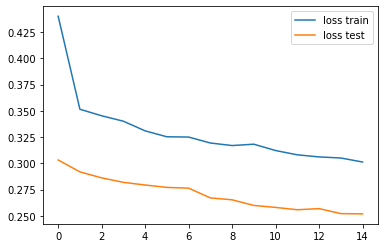

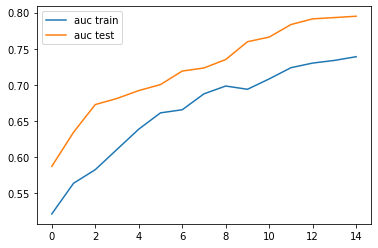

In [11]:
from matplotlib import pyplot
pyplot.plot(historyh.history['loss'], label='loss train')
pyplot.plot(historyh.history['val_loss'], label='loss test')
pyplot.legend()
pyplot.show()

#pyplot.plot(historyh.history['binary_accuracy'], label='accuracy train')
#pyplot.plot(historyh.history['val_binary_accuracy'], label='accuracy test')
#pyplot.plot(history.history['mse'], label='mse')
#pyplot.plot(history.history['mae'], label='mae')
#pyplot.legend()
#pyplot.show()

pyplot.plot(historyh.history['auc'], label='auc train')
pyplot.plot(historyh.history['val_auc'], label='auc test')
pyplot.legend()
pyplot.show()

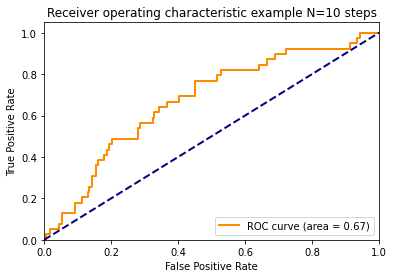

auc score:  0.673


In [12]:
AUC_roc_plot(y_test,y_test_pred_proba)

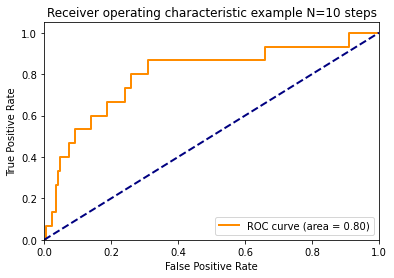

auc score:  0.796


In [13]:
AUC_roc_plot(y_val,y_val_pred_proba)

In [14]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, modelc.predict_classes(X_test))

C:\Users\Quantum\anaconda3\envs\Quantum\lib\site-packages\tensorflow\python\keras\engine\sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


array([[230,   1],
       [ 38,   1]], dtype=int64)

### 4.2.4 Freeze weights for Transfer Learning:

In [15]:
## Set to FALSE for transfer learning
clayerM.trainable = False
clayerF.trainable = False
clayerF1.trainable = False


## Using saved model
#saved_model.trainable = False
## alternatively
#for layer in saved_model.layers[:-1]:
 # layer.trainable = False


In [16]:
#get model weights
#modelh.layers[0].get_weights()

## 4.3 Training the Hybrid model:

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping , ModelCheckpoint

# Include classical and quantum layers 
modelh = tf.keras.models.Sequential([clayerM,clayerF,clayerF1,qlayer,clayerDropout,clayerD])
#modelh = tf.keras.Sequential([saved_model,qlayer,clayerD])

es = EarlyStopping(monitor='auc', min_delta=1e-9, patience=600, verbose=1) #'sparse_categorical_accuracy'


rp = ReduceLROnPlateau(monitor = 'val_loss', factor = 0.8, 
                                  patience = 10, min_delta = 0.001, 
                                  mode = 'min', verbose = 1)


modelh.compile(opt, loss='binary_crossentropy',
               metrics=[AUC(name = 'auc')])#'sparse_categorical_accuracy','categorical_accuracy','binary_accuracy', 'accuracy'])

modelh.build(input_shape=X_train.shape)

historyh = modelh.fit(X_train, y_train,
                      #validation_split = 0.1,    
                      validation_data=(X_val, y_val),
                      callbacks=[es, rp],
                      epochs=epochsH,
                      batch_size=batch_size,
                     shuffle=True)

modelh.summary()

Epoch 1/20


In [ ]:
modelc.get_weights()

In [ ]:
modelh.get_weights()

In [ ]:
for lay in modelc.layers:
    print(lay.name)
    print(lay.get_weights())

In [ ]:
for lay in modelh.layers:
    print(lay.name)
    print(lay.get_weights())

In [ ]:
# Make predictions on X_test
y_test_pred = (modelh.predict(X_test) > 0.5).astype("int32")
y_val_pred = (modelh.predict(X_val) > 0.5).astype("int32")

y_test_pred_proba = modelh.predict_proba(X_test)
y_val_pred_proba = modelh.predict_proba(X_val)

In [ ]:
from matplotlib import pyplot
pyplot.plot(historyh.history['loss'], label='loss train')
pyplot.plot(historyh.history['val_loss'], label='loss test')
pyplot.legend()
pyplot.show()

#pyplot.plot(historyh.history['binary_accuracy'], label='accuracy train')
#pyplot.plot(historyh.history['val_binary_accuracy'], label='accuracy test')
#pyplot.plot(history.history['mse'], label='mse')
#pyplot.plot(history.history['mae'], label='mae')
#pyplot.legend()
#pyplot.show()

pyplot.plot(historyh.history['auc'], label='auc train')
pyplot.plot(historyh.history['val_auc'], label='auc test')
pyplot.legend()
pyplot.show()

In [ ]:
AUC_roc_plot(y_test,y_test_pred_proba)

In [ ]:
AUC_roc_plot(y_val,y_val_pred_proba)

In [ ]:
confusion_matrix(y_test, modelh.predict_classes(X_test))